<a href="https://colab.research.google.com/github/FGalvao77/Predizendo-se-personagem-morre-ou-vive-em-GOT/blob/main/Predizendo_se_personagem_morrer%C3%A1_ou_viver%C3%A1_em_GOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Game of Thrones**
 - Explorando este mundo de fantasia!

`A curiosidade aqui é saber, dadas algumas características dos personagens, seja elas pessoais e ou do meio em que vivem, terá maior probabilidades de viver ou não.`

> ## **Importando as bibliotecas necessárias**

In [1]:
from sklearn import datasets  # sklearn é uma das lib mais utilizadas em ML, ela contém, além dos 
                              # datasets, várias outras funções úteis para a análise de dados
                              # essa lib será sua amiga durante toda sua carreira
import pandas as pd  # importa a lib Pandas. Essa lib é utilizada para lidar com dataframes (TABELAS) 
                     # de forma mais amigável. 
from sklearn.model_selection import train_test_split,KFold,cross_val_score, cross_val_predict # esse método é utilizado para dividir o 
                                                                                              # conjunto de dados em grupos de treinamento e test
from sklearn.svm import SVC      #importa o algoritmo svm para ser utilizado 
from sklearn import tree         # importa o algoritmo arvore de decisão
from sklearn.linear_model import LogisticRegression # importa o algoritmo de regressão logística
from sklearn.metrics import mean_absolute_error # utilizada para o calculo do MAE
from sklearn.metrics import mean_squared_error # utilizada para o calculo do MSE
from sklearn.metrics import r2_score # utilizada para o calculo do R2
from sklearn import metrics  # utilizada para as métricas de comparação entre os métodos
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm


In [2]:
# realizando o carregamento do conjunto de dados para google colab
from google.colab import files  # biblioteca utilizada para carregar os dados para o google colab
uploaded = files.upload()

Saving character-predictions.csv to character-predictions.csv


In [3]:
# realiza a leitura do dataset
got_dataset = pd.read_csv('character-predictions.csv')  

> ## **Análise exploratória e tratamento dos dados**

In [4]:
# conhecendo o dataset
got_dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

In [5]:
# visulaizando as 5 primeiras linhas
got_dataset.head()  

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,105.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [6]:
# contando a quantidade de valores nulos
nans = got_dataset.isna().sum() 
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [7]:
# tamanho do dataset
len(got_dataset)

1946

In [9]:
# visualizando a dimensão geral do dataset
got_dataset.shape     # linhas e coluna

(1946, 33)

In [8]:
# analisando os dados nulos
print(got_dataset['age'].mean()) 

-1293.5635103926097


>> **Média negativa para a idade!?**
  - possível erro no nosso dataset


In [12]:
# realizando uma maior análise referente a idade e associando-a ao personagem
print('')
print(got_dataset['age'][got_dataset['age'] < 0])

1684    Doreah
1868    Rhaego
Name: name, dtype: object

1684   -277980.0
1868   -298001.0
Name: age, dtype: float64


**Vamos tratar os valores nulos!**

In [13]:
# substituindo os valores negativos
got_dataset.loc[1684, 'age'] = 25.0
got_dataset.loc[1868, 'age'] = 0.0

In [14]:
print(got_dataset['age'].mean())   # verificando novamente a média da idade

36.70438799076212


In [15]:
# agora vamos tratar os dados nulos
got_dataset['age'].fillna(got_dataset['age'].mean(), inplace=True) # substituindo os valores nulos pela média da coluna
got_dataset['culture'].fillna('', inplace=True) # preenchendo os valores nulos da coluna cultura com uma string nula (vazia)

# preenchendo os demais valores com -1
got_dataset.fillna(value=-1, inplace=True)

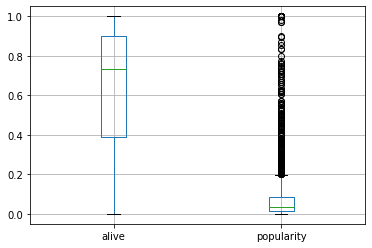

In [17]:
# realizando a plotangem do boxplot 
got_dataset.boxplot(['alive','popularity']);    # perceba que, temos muitos valores acima do limite do boxplot

>> ## **Esses dados fora da caixa é popularmente conhecido como `outliers`**.

**BOXPLOT: COMO INTERPRETAR?** por _Operdata_
- https://bit.ly/3vkE59O

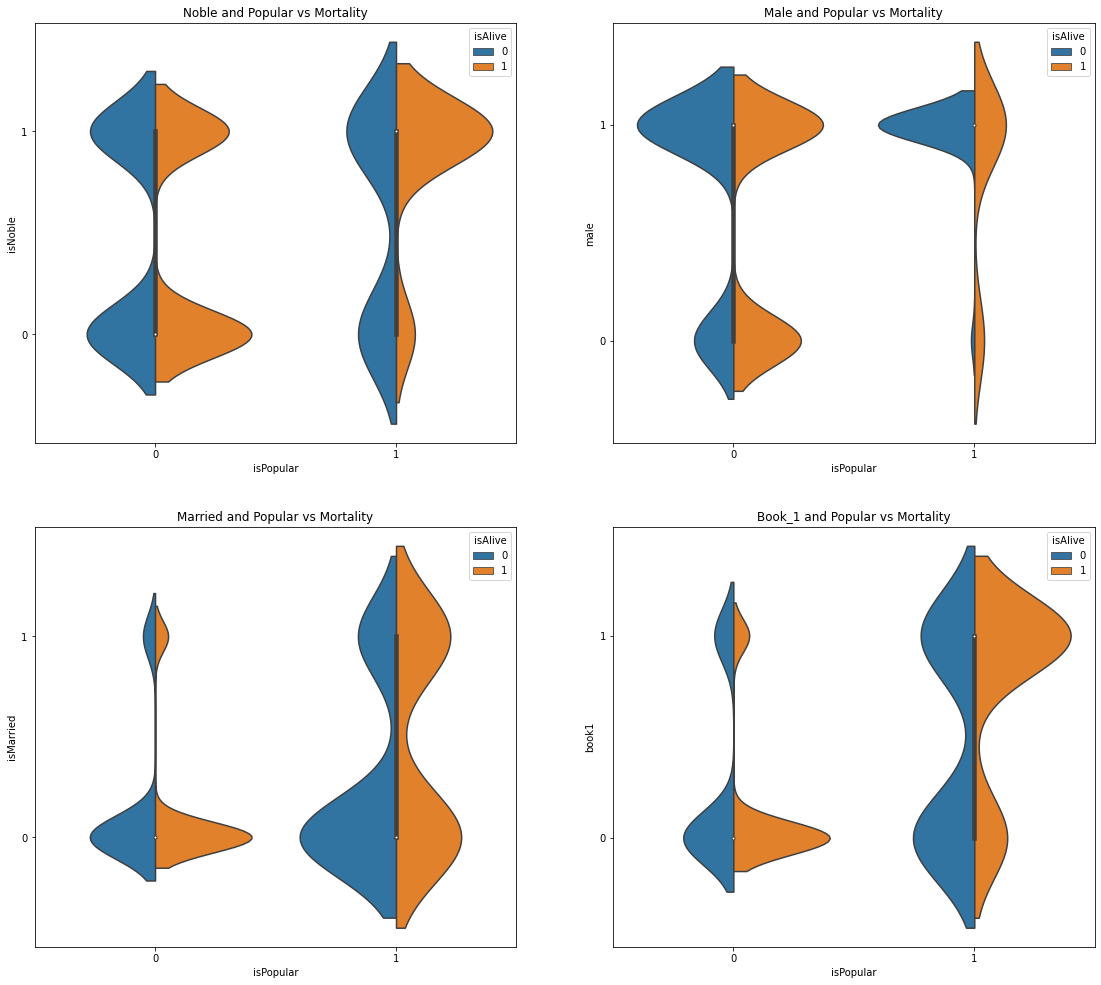

In [20]:
# analisando a "mortalidade" dos personagens

# iremos plotar um gráfico de violino, onde iremos analisar as seguintes questões:
  # sua popularidade;
  # sua linhagem;
  # seu gênero;
  # livro 01

# essas relações para o personagem está vivo ou não
# obs.: aqui estamos analisando essas relações somente do "book1"
  # e poderíamos extrapolar essa análise para os demais livros, fica ao seu critério e curiosidade em fazer isso!

import warnings   # biblioteca para ignorar alertas  
warnings.filterwarnings('ignore')

# configurando a exibição dos gráficos
f,ax=plt.subplots(2,2,figsize=(19,17))
sns.violinplot('isPopular', 'isNoble', hue='isAlive', data=got_dataset ,split=True, ax=ax[0, 0])
ax[0, 0].set_title('Noble and Popular vs Mortality')
ax[0, 0].set_yticks(range(2))

sns.violinplot('isPopular', 'male', hue='isAlive', data=got_dataset ,split=True, ax=ax[0, 1])
ax[0, 1].set_title('Male and Popular vs Mortality')
ax[0, 1].set_yticks(range(2))

sns.violinplot('isPopular', 'isMarried', hue='isAlive', data=got_dataset ,split=True, ax=ax[1, 0])
ax[1, 0].set_title('Married and Popular vs Mortality')
ax[1, 0].set_yticks(range(2))


sns.violinplot('isPopular', 'book1', hue='isAlive', data=got_dataset ,split=True, ax=ax[1, 1])
ax[1, 1].set_title('Book_1 and Popular vs Mortality')
ax[1, 1].set_yticks(range(2))


plt.show();

In [21]:
# analisando as correlações entre as variáveis
correlations = got_dataset.corr()
correlations

,S.No,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,1.000000,-0.128708,-0.168569,-0.181493,0.181493,0.117225,0.048868,0.058524,0.290130,0.312403,0.368665,0.284554,0.405907,-8.261373e-02,-8.715181e-02,-1.105378e-01,0.148926,0.150648,0.241642,1.200537e-02,0.092734,0.171157,0.170451,0.277761,-0.128712
actual,-0.128708,1.000000,0.359028,0.420795,-0.420795,-0.144552,-0.055576,-0.085345,-0.147401,-0.067200,0.006693,0.268975,0.032846,-1.406607e-01,-1.236150e-01,-1.163646e-01,-0.031536,-0.050037,-0.042211,-1.322748e-01,-0.192444,-0.193736,-0.153860,-0.183174,0.997291
pred,-0.168569,0.359028,1.000000,0.894427,-0.894427,-0.193754,-0.048661,-0.069246,-0.220113,-0.107290,0.008003,0.307838,-0.089181,-1.495955e-01,-1.405573e-01,-1.437093e-01,-0.106217,-0.125874,-0.111793,-1.065300e-01,-0.260960,-0.276936,-0.286736,-0.344108,0.356483
alive,-0.181493,0.420795,0.894427,1.000000,-1.000000,-0.199020,-0.035081,-0.080436,-0.241441,-0.143350,-0.026135,0.404151,-0.059397,-1.797968e-01,-1.676020e-01,-1.685658e-01,-0.140335,-0.161908,-0.101990,-1.312548e-01,-0.277407,-0.292399,-0.281480,-0.354584,0.417318
plod,0.181493,-0.420795,-0.894427,-1.000000,1.000000,0.199020,0.035081,0.080436,0.241441,0.143350,0.026135,-0.404151,0.059397,1.797968e-01,1.676020e-01,1.685658e-01,0.140335,0.161908,0.101990,1.312548e-01,0.277407,0.292399,0.281480,0.354584,-0.417318
male,0.117225,-0.144552,-0.193754,-0.199020,0.199020,1.000000,-0.041061,0.013475,0.084876,0.060322,0.023364,-0.063178,0.062387,6.762172e-02,7.925039e-02,8.236750e-02,-0.054626,-0.081611,0.156171,3.787654e-02,0.041736,0.053249,0.129207,0.140828,-0.146982
dateOfBirth,0.048868,-0.055576,-0.048661,-0.035081,0.035081,-0.041061,1.000000,-0.000823,0.066335,0.044929,0.005444,-0.002360,0.008022,-3.836683e-03,-4.195891e-03,-3.991488e-03,-0.010713,-0.011032,-0.029837,-6.645764e-02,0.067540,0.057399,-0.005602,0.013912,-0.055596
DateoFdeath,0.058524,-0.085345,-0.069246,-0.080436,0.080436,0.013475,-0.000823,1.000000,0.092930,-0.010258,-0.020110,-0.056069,-0.013101,-5.032759e-03,-5.503949e-03,-5.235824e-03,0.017583,0.014168,-0.041901,-4.661748e-03,0.031517,0.031254,0.037199,0.024001,-0.085345
book1,0.290130,-0.147401,-0.220113,-0.241441,0.241441,0.084876,0.066335,0.092930,1.000000,0.392439,0.243843,0.079959,0.264818,-5.022186e-02,-4.599173e-02,-5.224824e-02,0.091831,0.085895,0.095848,-3.822908e-03,0.191853,0.241630,0.252426,0.324782,-0.147401
book2,0.312403,-0.067200,-0.107290,-0.143350,0.143350,0.060322,0.044929,-0.010258,0.392439,1.000000,0.449931,0.175937,0.225677,-7.814116e-02,-7.809839e-02,-8.129406e-02,0.157695,0.157045,0.023366,-1.004350e-01,0.075281,0.124040,0.139210,0.247918,-0.067200


**Vamos melhor essa visualização!**
  - plotando um gráfico de calor

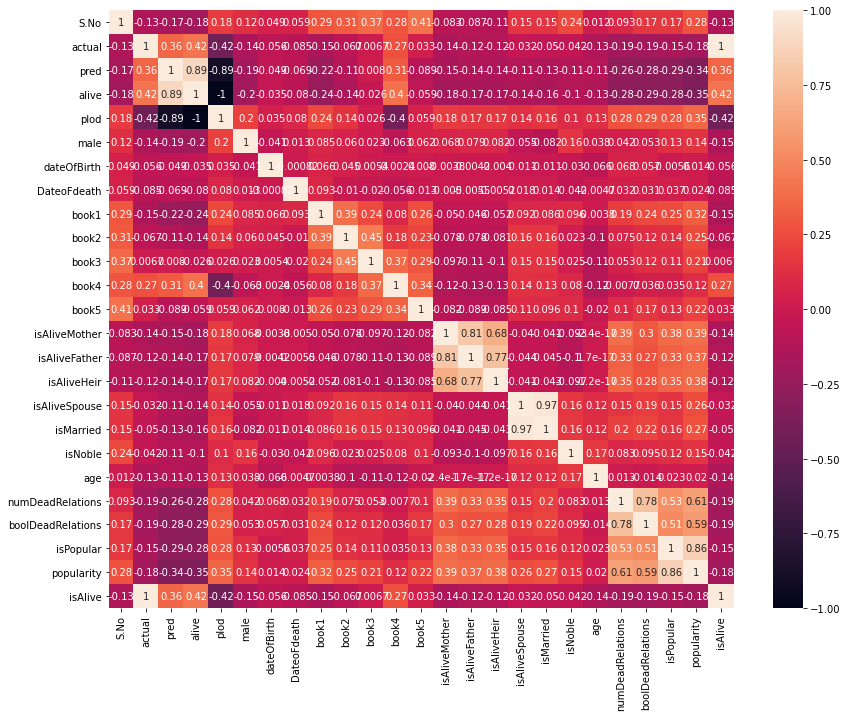

In [22]:
# plotando gráfico de calor para uma melhor visualização da correlação 
corr = got_dataset.corr()
ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10});

In [23]:
# retirando algumas colunas 
drop = ["S.No", "pred", "alive", "plod", "name", "isAlive", "DateoFdeath"]
got_dataset.drop(drop, inplace=True, axis=1)

# salvando uma cópia do dataset para aplicar o hotencoder
got_dataset_2 = got_dataset.copy(deep=True)

In [24]:
# transformando os dados categóricos em one-hot-encoder
got_dataset = pd.get_dummies(got_dataset)

In [25]:
# visualizando as 5 primeiras linhas
got_dataset.head()    # perceba que, as colunas com dados categóricos foram transformados em dados numéricos

,actual,male,dateOfBirth,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,title_-1,title_Acorn Hall,title_Andals,title_Arbor,title_Archmaester,title_Ashford,title_Banefort,title_Barrowton,title_Bear Island,title_Big BucketThe Wull,title_Bitterbridge,title_Black Wind,title_Blackcrown,title_Blackmont,title_Blacktyde,title_Bloodrider,title_Blue Grace,title_Brightwater,title_Broad Arch,title_Brother,title_BrotherProctor,...,spouse_Shiera Crakehall,spouse_Shierle Swyft,spouse_Sigorn,spouse_Simon Staunton,spouse_Stannis Baratheon,spouse_Steffon Baratheon,spouse_Stevron Frey,spouse_Stonetree,spouse_Sybell Spicer,spouse_Sybelle Glover,spouse_Sylva Santagar,spouse_Sylwa Paege,spouse_Symond Frey,spouse_Taena of Myr,spouse_Teora Kyndall,spouse_Theodore Tyrell,spouse_Theomar Smallwood,spouse_Titus Peake,spouse_Tya Lannister,spouse_Tyana Wylde,spouse_Tygett Lannister,spouse_Tyrek Lannister,spouse_Tyrion Lannister,spouse_Tysha,spouse_Tytos Frey,spouse_Tywin Lannister,spouse_Victaria Tyrell,spouse_Viserys I Targaryen,spouse_Walder Frey,spouse_Walter Whent,spouse_Walton Frey,spouse_Whalen Frey,spouse_Willam Dustin,spouse_Wylis Manderly,spouse_Wynafrei Whent,spouse_Yandry,spouse_Ynys Yronwood,spouse_Ysilla,spouse_Ysilla Royce,spouse_Zhoe Blanetree
0,0,1,-1.0,0,0,0,0,0,1.0,0.0,0.0,-1.0,0,0,36.704388,11,1,1,0.605351,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,208.0,1,1,1,1,1,-1.0,-1.0,-1.0,1.0,1,1,97.000000,1,1,1,0.896321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,-1.0,0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,0,1,36.704388,0,0,0,0.267559,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,82.0,0,0,0,0,0,-1.0,-1.0,-1.0,0.0,1,1,23.000000,0,0,0,0.183946,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,276.0,0,0,0,1,0,-1.0,-1.0,-1.0,1.0,1,1,29.000000,0,0,0,0.043478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


>> **Essa transformação é necessária, já que os modelos preditivos trabalham com dados numéricos**

**Se houver dúvidas o `por que` dessa transformação segue o link de duas pequenas matéria explicativa.**
 - https://bit.ly/2RYwgbo
 - https://bit.ly/3dXpawB

**Ou se quiser um melhor aprofundamento (aconselho ler!), nada melhor que à consulta da documentação do `Scikit-learn` sobre o _OneHotEncoder_**.
 - https://bit.ly/3vAKsWT

> ## **Aplicando os modelos e avaliando à sua performance**

In [26]:
# separando o dataset entre entradas e saídas
x = got_dataset.iloc[:,1:].values
y = got_dataset.iloc[:, 0].values   # nosso alvo 

In [27]:
# aplicando o modelo de validação cruzada
# divide o dataset entre 5 diferentes grupos
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

>> **Link da documentação do `KFold`**
  - https://bit.ly/3vs12In

In [28]:
# construindo os modelos de classificação
modelos = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=42), 
          DecisionTreeClassifier(random_state=42), svm.SVC(kernel='rbf', gamma='scale', random_state=42), 
          KNeighborsClassifier()]

In [29]:
# utilizando a validação cruzada
mean=[]
std=[]

for model in modelos:
    result = cross_val_score(model, x, y, cv=kfold, scoring='accuracy', n_jobs=-1)
    mean.append(result)
    std.append(result)

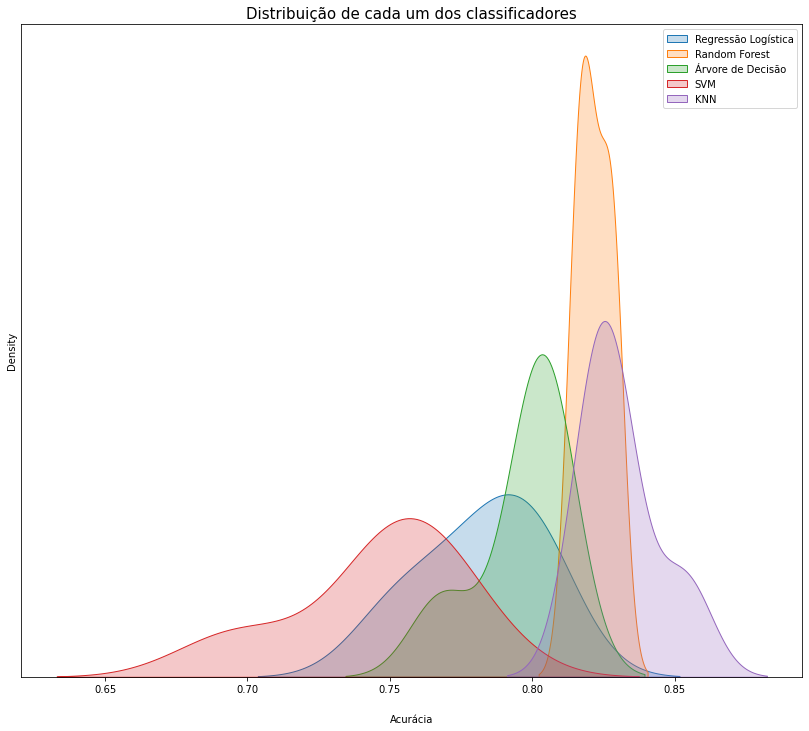

In [32]:
# plotando o gráfico com os modelos e suas respectivas performances
classificadores=['Regressão Logística', 'Random Forest', 'Árvore de Decisão', 'SVM', 'KNN']

plt.figure(figsize=(14, 12))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={'shade': True})
    
plt.title('Distribuição de cada um dos classificadores', fontsize=15)
plt.legend(classificadores)
plt.xlabel('Acurácia', labelpad=20)
plt.yticks([])

plt.show();

>> ## **Realizando a previsão dos classificadores**

- **Quais algoritmos escollher?**

> ## **A partir daqui, se houver dúvidas quanta à utilização de alguma biblioteca e/ou modelo, consulte a documentação oficial!**
 - o nosso amigo `Google` pode ter auxiliar em muito ; )

In [33]:
# dividindo o dataset entre treinamento 80% e teste 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=42)

In [40]:
# escolhendo o svm e a floresta randomica
svm_clf = svm.SVC(C=0.9, gamma=0.1, kernel='rbf', probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

# treinando os modelos
svm_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [41]:
# obtendo as probabilidades previstas
svm_prob = svm_clf.predict_proba(x_test)
rf_prob = rf_clf.predict_proba(x_test)

# valores reais
svm_preds = np.argmax(svm_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)

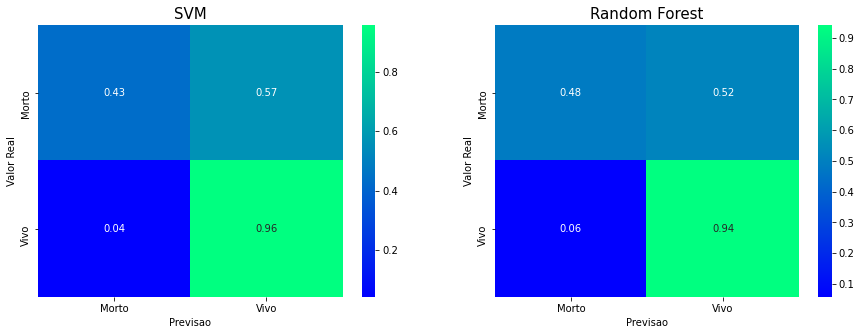

In [44]:
# analisando os modelos 
cm = metrics.confusion_matrix(y_test, svm_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm2 = metrics.confusion_matrix(y_test, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[: , np.newaxis]

classes = ['Morto', 'Vivo']
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('SVM', fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, 
            fmt='.2f', ax=ax[0]).set(xlabel='Previsao', ylabel='Valor Real')

ax[1].set_title('Random Forest', fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', 
            ax=ax[1]).set(xlabel='Previsao', ylabel='Valor Real');

>> ## **Grand finale!**

Chegamos ao final, com as probabilidades dos modelos em prever se um personagem está `Morto` ou `Vivo`.

_No geral, essa análise com a base de dados do **GOT** foi meramente didática para apredermos as técnicas necessárias para realizarmos predições e, nada melhor que aplicar essas mesmas técnicas em uma base de dados do mundo real!_

**Então tente e explore essa possibilidade!**